# 10 armed testbed

This notebook implements the 10-armed-testbed in Julia. The Julia programming language was used since it is a relatively newish language focused on fast numeric computing. It is emerging as an alternative to R and Python in the general data science/machine learning industry and thus also fitting for reinforcement learning.

The functions are implemented in a general purpose manner.

In [1]:
using Statistics
using Plots

In [2]:
epsilons = [0.5 0.1 0.01]
k = 10
steps = 1000
ground_truths = randn(k)
optimal_action = argmax(ground_truths)
runs = 1000;

In [3]:
"Pulls the lever of the imaginary bandit and returns the reward"
function bandit(ground_truths, action)
    rand() + ground_truths[action]
end

bandit

In [4]:
"Updates an estimate using the old estimate, the target and a step size"
function update_estimate(old, target, step_size)
    old + step_size * (target - old)
end

update_estimate

In [5]:
"""
Performs a step of the k-armed bandit. An explorative or greedy action is chosen and the reward is collected.
Then, the value estimates are updated.

# Arguments
- `step_size::Float=nothing`: Use 1/n (i.e. sample averaging) if nothing
"""
function step(actions_taken, estimates, greedyness, ground_truths, k, step_size=nothing)
    explore = rand() < greedyness
    if explore
        action = rand(1:k)
    else
        action = argmax(estimates)
    end
    reward = bandit(ground_truths, action)
    if isdefined(step_size, :num)
        alpha = step_size
    else
        amount = sum(actions_taken .== action)
        alpha = 1 / (amount + 1)
    end
    estimates[action] = update_estimate(estimates[action], reward, alpha)
    action, reward
end

step

In [6]:
"""
Trains the agent on a k-armed bandit problem for `steps` steps. In each step, the agent performs an action and receives a reward.
The rewards are used to compute the value estimates.

# Arguments
- `step_size::Float=nothing`: Use 1/n (i.e. sample averaging) if nothing

# Returns
- rewards collected
- actions taken
- value estimates
"""
function train(k, steps, greedyness, ground_truths, step_size=nothing)
    estimates = fill(0., k)
    actions_taken = fill(0, steps)
    rewards = fill(0., steps)
    for s in 1:steps
        action, reward = step(actions_taken, estimates, greedyness, ground_truths, k, step_size)
        actions_taken[s] = action
        rewards[s] = reward
    end
    rewards, actions_taken, estimates
end

train

The following loop executes the experiment. For each epsilon, the testbed is run independently 1000 times for 1000 steps. Ehe results are averaged and plotted.

In [7]:
avg_rewards_per_epsilon = []
avg_perc_optimal_action_per_epsilon = []
for epsilon in epsilons
    overall_rewards = zeros(runs, steps)
    overall_perc_optimal_action = zeros(runs, steps)
    for run in 1:runs
        rewards, actions_taken = train(k, steps, epsilon, ground_truths)
        overall_rewards[run,:] = rewards
        overall_perc_optimal_action[run,:] = (cumsum(actions_taken .== optimal_action) ./ (1:steps))
    end

    avg_rewards = transpose(mean(overall_rewards, dims=1))
    push!(avg_rewards_per_epsilon, avg_rewards)
    avg_perc_optimal_action = transpose(mean(overall_perc_optimal_action, dims=1))
    push!(avg_perc_optimal_action_per_epsilon, avg_perc_optimal_action)
end

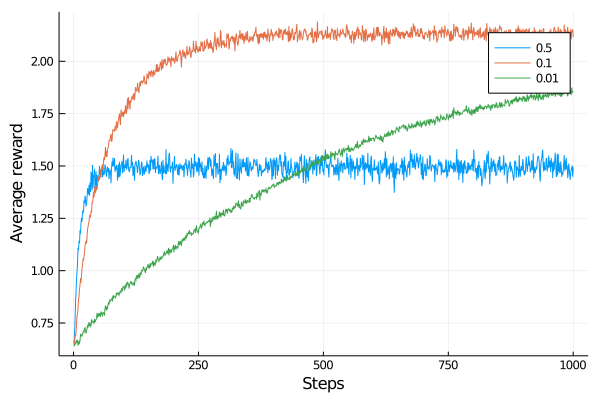

In [8]:
gr()
plot(
    avg_rewards_per_epsilon,
    label = epsilons,
    xlabel = "Steps",
    ylabel = "Average reward"
)

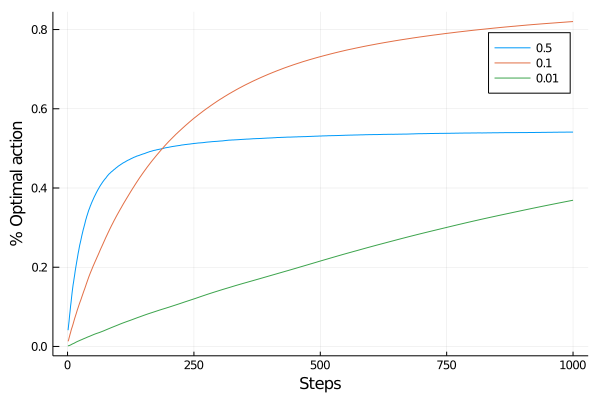

In [9]:
plot(
    avg_perc_optimal_action_per_epsilon,
    label = epsilons,
    xlabel = "Steps",
    ylabel = "% Optimal action"
)

One sees in the results that the 0.1-greedy agent performed the best. However, it is clear that with a longer task (i.e. a larger step paramter), the 0.01-greedy agent will outperform the 0.1-greedy agent. An interesting domain to look at are the first steps, in which the 0.5-greedy agent outperforms the other agents.